In [0]:
import pandas as pd
import numpy as np
from scipy.stats import randint
import seaborn as sns # used for plot interactive graph. 
import matplotlib.pyplot as plt
import seaborn as sns
from io import StringIO
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics

In [2]:
#Open drugreview files
df_train=pd.read_csv("drugsComTrain_raw.csv")
print("Train Data format " ,df_train.head())
print("Train Data shape ",df_train.shape)
print("Condition count in Train dataset ", df_train['condition'].value_counts())
df_train_cond_rev=df_train[['condition','review']].copy()
df_temp=df_train_cond_rev[pd.notnull(df_train_cond_rev['review'])]
df_train_fil=df_temp[pd.notnull(df_temp['condition'])]
print("Dataset with columns Condition and review" , df_train_fil)
print("Dataset with columns Condition and review dimension " ,df_train_fil.shape)

Train Data format     uniqueID                  drugName  ...       date usefulCount
0    206461                 Valsartan  ...  20-May-12          27
1     95260                Guanfacine  ...  27-Apr-10         192
2     92703                    Lybrel  ...  14-Dec-09          17
3    138000                Ortho Evra  ...   3-Nov-15          10
4     35696  Buprenorphine / naloxone  ...  27-Nov-16          37

[5 rows x 7 columns]
Train Data shape  (161297, 7)
Condition count in Train dataset  Birth Control                    28788
Depression                        9069
Pain                              6145
Anxiety                           5904
Acne                              5588
                                 ...  
Meningitis, Meningococcal            1
Gonadotropin Inhibition              1
Cerebrovascular Insufficiency        1
Strabismus                           1
Tuberculosis, Active                 1
Name: condition, Length: 884, dtype: int64
Dataset with columns Condit

In [3]:
# Clean patient condition label with bad data
df_comment = df_train_fil[df_train_fil['condition'].str.contains('comment')]
df_comment

,condition,review
105,2</span> users found this comment helpful.,"""I&#039;m 16 and I have been on Loestrin 24 f..."
196,4</span> users found this comment helpful.,"""I&#039;m 24 years old and have always had a p..."
243,3</span> users found this comment helpful.,"""I took Yaz for a little over 2 years. From a..."
264,4</span> users found this comment helpful.,"""Took this pill for 1.) Acne and 2.) Birth Con..."
391,11</span> users found this comment helpful.,"""I have suffered with low back pain - 2 surger..."
...,...,...
160322,99</span> users found this comment helpful.,"""Great pill... You can definitely see it worki..."
160791,62</span> users found this comment helpful.,"""I am sharing a painful experience actually. T..."
160899,7</span> users found this comment helpful.,"""I&#039;ve been taking Geodon for about a mont..."
160921,92</span> users found this comment helpful.,"""At 300mg 4x daily my pain was almost gone. """


In [4]:
# Dropping rows that contain incorrect information 

df_train_fil = df_train_fil[~df_train_fil['condition'].str.contains('comment')]
print(df_train_fil.shape)

(159498, 2)


Birth Control                 28788
Depression                     9069
Pain                           6145
Anxiety                        5904
Acne                           5588
                              ...  
me                                1
Sepsis                            1
Zollinger-Ellison Syndrome        1
Pemphigoid                        1
Hypodermoclysis                   1
Name: condition, Length: 811, dtype: int64


Text(0.5, 1.0, 'Top 50  : The number of reviews per patient condition.')

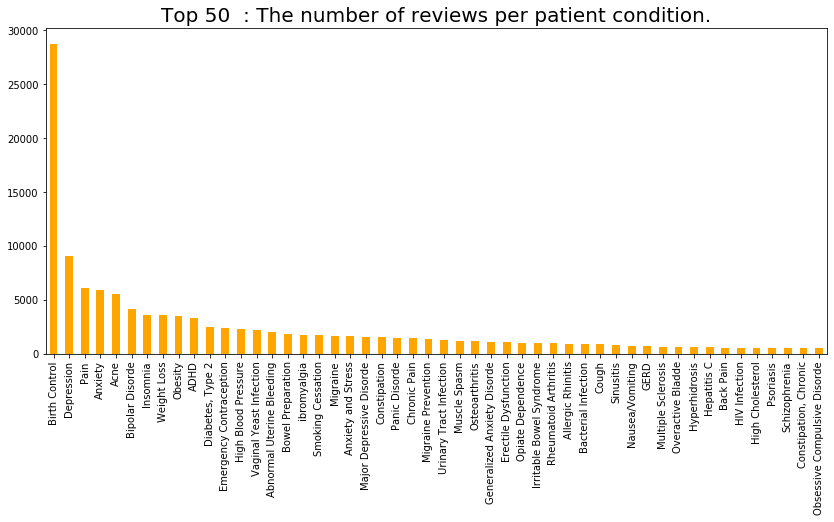

In [5]:
# Data plot based on review and condition
df_condition=df_train_fil.condition.value_counts()
print(df_condition)
df_condition[0:50].plot(kind="bar", figsize = (14,6), fontsize = 10,color="orange")
plt.xlabel("", fontsize = 20)
plt.ylabel("", fontsize = 20)
plt.title("Top 50  : The number of reviews per patient condition.", fontsize = 20)

In [6]:
value_counts=df_train_fil['condition'].value_counts()
# Select the values where the count is less than 3 (or 5 if you like)
print(value_counts)

Birth Control                 28788
Depression                     9069
Pain                           6145
Anxiety                        5904
Acne                           5588
                              ...  
me                                1
Sepsis                            1
Zollinger-Ellison Syndrome        1
Pemphigoid                        1
Hypodermoclysis                   1
Name: condition, Length: 811, dtype: int64


In [7]:

to_remove = value_counts[value_counts <= 800].index
# Keep rows where the city column is not in to_remove
df_train_fil = df_train_fil[~df_train_fil.condition.isin(to_remove)]
print(" Dataset after removal",df_train_fil.shape)
df_train_fil.condition.value_counts()

 Dataset after removal (114796, 2)


Birth Control                  28788
Depression                      9069
Pain                            6145
Anxiety                         5904
Acne                            5588
Bipolar Disorde                 4224
Insomnia                        3673
Weight Loss                     3609
Obesity                         3568
ADHD                            3383
Diabetes, Type 2                2554
Emergency Contraception         2463
High Blood Pressure             2321
Vaginal Yeast Infection         2274
Abnormal Uterine Bleeding       2096
Bowel Preparation               1859
ibromyalgia                     1791
Smoking Cessation               1780
Migraine                        1694
Anxiety and Stress              1663
Major Depressive Disorde        1607
Constipation                    1595
Panic Disorde                   1463
Chronic Pain                    1455
Migraine Prevention             1413
Urinary Tract Infection         1316
Muscle Spasm                    1244
O

In [0]:
df_train_fil.replace({'condition':{'Generalized Anxiety Disorde': 'Anxiety Disorder','Anxiety and Stress': 'Anxiety Disorder','Anxiety':'Anxiety Disorder','Major Depressive Disorde':'Depression'}},inplace= True)

In [9]:
df_train_fil.condition.unique()

array(['ADHD', 'Birth Control', 'Opiate Dependence',
       'Emergency Contraception', 'Bipolar Disorde',
       'Migraine Prevention', 'Depression', 'Cough', 'Obesity',
       'Urinary Tract Infection', 'ibromyalgia', 'Insomnia',
       'Rheumatoid Arthritis', 'Vaginal Yeast Infection', 'Panic Disorde',
       'Migraine', 'Pain', 'Irritable Bowel Syndrome', 'Osteoarthritis',
       'Constipation', 'Bowel Preparation', 'Muscle Spasm',
       'Diabetes, Type 2', 'Smoking Cessation', 'Anxiety Disorder',
       'Acne', 'Erectile Dysfunction', 'Chronic Pain',
       'High Blood Pressure', 'Allergic Rhinitis',
       'Abnormal Uterine Bleeding', 'Weight Loss', 'Bacterial Infection',
       'Sinusitis'], dtype=object)

Birth Control                28788
Depression                   10676
Anxiety Disorder              8731
Pain                          6145
Acne                          5588
Bipolar Disorde               4224
Insomnia                      3673
Weight Loss                   3609
Obesity                       3568
ADHD                          3383
Diabetes, Type 2              2554
Emergency Contraception       2463
High Blood Pressure           2321
Vaginal Yeast Infection       2274
Abnormal Uterine Bleeding     2096
Bowel Preparation             1859
ibromyalgia                   1791
Smoking Cessation             1780
Migraine                      1694
Constipation                  1595
Panic Disorde                 1463
Chronic Pain                  1455
Migraine Prevention           1413
Urinary Tract Infection       1316
Muscle Spasm                  1244
Osteoarthritis                1239
Erectile Dysfunction          1086
Opiate Dependence             1079
Irritable Bowel Synd

Text(0.5, 1.0, 'Top 34  : The number of reviews per patient condition.')

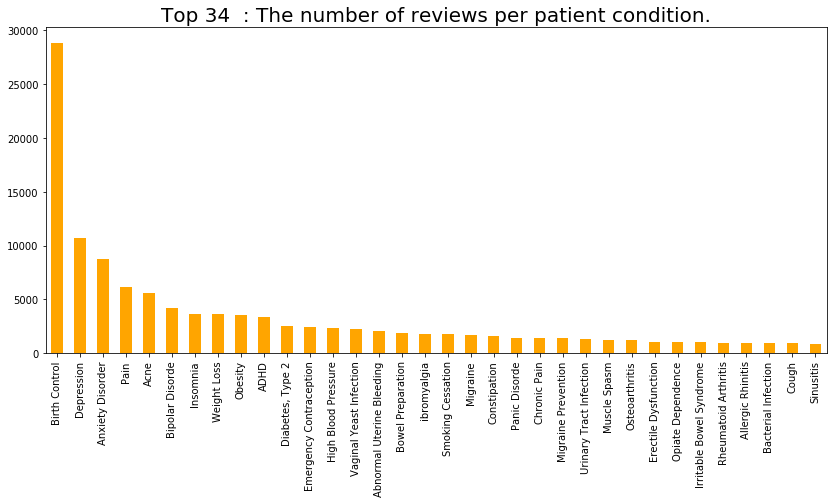

In [10]:
# Data plot based on review and condition
df_condition=df_train_fil.condition.value_counts()
print(df_condition)
df_condition[0:34].plot(kind="bar", figsize = (14,6), fontsize = 10,color="orange")
plt.xlabel("", fontsize = 20)
plt.ylabel("", fontsize = 20)
plt.title("Top 34  : The number of reviews per patient condition.", fontsize = 20)

In [11]:
df_train_fil = df_train_fil.sample(frac=0.5, replace=True, random_state=1).copy()
df_train_fil.shape

(57398, 2)

In [13]:
#Clean review comments
import re
import nltk
#nltk.download('stopwords')
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@\d+]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z00-99 #+_]')
add_stop = ['', ' ', 'say', 's', 'u', 'ap', 'afp', '...', 'n', '\\','this','will','doctor','took','got','month','an','weight','if','one','week','when','more','are','weeks','are','would','just','feel','day',
 'im','though','daily','found','daily','found','give','7','gained','happy','sure','told','less','gave','three',
 'side','taking','ive','years','first','effects','take','started','like','months','get','days','time','2','feel','would','3',
 'back', 'also','dont','since', 'also','dont','since', 'cant','stop','morning','however','taken','within','see''good','night',
 'even','year','great','ago','4','tried','little','5','dose','used','worked','1','getting','could','10','almost','put','6','use',
 'nothing','far','helped','normal','gain','recommend','without','long','thing','make','many','noticed','said','ood','best',
 'thought','gone','working','couldnt','anything','something','spotting','things','people','second','need','20','way','half',
 'start','another','completely','wasnt','everything','8','face','bit','high','worth','definitely','pretty','decided','actually',
 'lbs','effective','past','today','helps','heavy','new','may','doesnt','30','minutes','15','problem','dry','came','reviews','shot','issues','trying','switched','depressed','12','full','sometimes','find','meds','change','anyone','caused','thats','results','done','increased','twice','energy','fine','several','hard','read','given','pressure','come','clear','eating','already','insurance','everyone','dosage','mouth','amazing','id','enough','wanted','overall','maybe','began','really','still','never','much','work','went','two','didnt','go','made','works','going','mg','hours','last','ever','lost','lot','try','think','stopped',
 'away','know','times','always','havent','next','due','want','around','experienced','finally','able','right','later','different','hour','keep','dr','changed','makes','least','else','difference','seems','needed','product',
 'point','soon','absolutely','anymore','usually','drink','free','stay','became','recently','awful','small','hoping','believe','felt','better','good','every','well','help','feeling','prescribed','severe','experience','using','effect','worse','body','old','love','see','symptoms','eat','drive','problems','light','starting','insertion','attacks','hope','bed','plan','negative','crazy','major','9','whole','gotten','quit','removed','extreme','food','pack','lasted','end','patch','everyday','constant','person','25','reason','others','medications','thoughts','24','yet','tell','reading','etc','regular','although','suffered','cause','10mg','along','asleep','wake','remember','medicines','100','doctors','hair','left','immediately','hurt','part','constantly','school','per','highly','burning','mind','break','positive','b','super','slight','big','short','head','notice','probably','cycle','deal','cleared','either','woke','seem','wish','increase','wait','boyfriend','let','four','50','18','wouldnt','scared','23','20mg','quite','stuff','continue','takes','thinking','literally','worry','beginning','might','recommended','treatment','early','plus','experiencing','taste','home','seemed','huge','ended','kept','easy','husband','doc','hungry','suffer','crying','wont','third','switch','except','become','isnt','prescription','making','16','coming','family','40','fall','yes','goes','luck','quickly','entire','2015','currently','looking','fast','glad','fatigue','attack','please','straight','yrs','2nd','can','not','thank','dreams','withdrawal','trouble','3rd','cream','happened','fact','function','care','often','kind','50mg','hate','kids','amount','late','especially','instead','gets','switching','wonderful','issue','changes','losing','chest','saved','broke','level','worried','live','totally','loved','14','lighter','type','active','nearly','age','prior','feels','intense','real','1st','son','45','rather','baby','decreased','improved','slowly','someone','focus','self','lots','size','normally','5mg','hospital','irregular','six','yesterday','nervous','rest','cry','uncomfortable','supposed','hopefully','guess','drinking','procedure','knew','called','improvement','giving','11','34','youre','walk','form','asked','slightly','developed','bathroom','expensive','suggested','17','look','okay','sleepy','ok','eventually','course','add','2016','knee','stick','must','brand','five','sensitive','health','wonders','minor','child','comes','none','breakouts','hasnt','adderall','saw','cost','review','unfortunately','red','100mg','leave','affects','occasional','helping','hot','breakthrough','serious','possible','usual','zero','single','pay','perfect','levels','hell','nights','sad','legs','total','friends','handle','doses','seen','difficult','prep','easily','13','throughout','slept','minimal','god','social','continued','turned','mine','reduced','seeing','strong','term','ready','truly','upset','happen','lasts','unbearable','wrong','rid','mostly','evening','says','unprotected','march','case','children','place','25mg','vyvanse','moderate','awesome','pm','reaction','post','60','female','causing','higher','easier']

STOPWORDS = set(stopwords.words('english'))
stop_words=STOPWORDS.union(add_stop)
def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
        # remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    
    # remove the characters [\], ['] and ["]
    text = re.sub(r"\\", "", text)    
    text = re.sub(r"\'", "", text)    
    text = re.sub(r"\"", "", text)    
    
    # convert text to lowercase
    text = text.strip().lower()
    text = BeautifulSoup(text, "lxml").text # HTML decoding
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = BAD_SYMBOLS_RE.sub('', text) # delete symbols which are in BAD_SYMBOLS_RE from text
    text = ' '.join(word for word in text.split() if word not in stop_words) # delete stopwors from text
    return text
    
df_train_fil['review'] = df_train_fil['review'].apply(clean_text)
#print_plot(10)
df_train_fil

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


,condition,review
138414,Pain,neurontin nerve pain associated paralysis leg ...
109133,Depression,depression psychology study suicidal selfcontr...
7319,ibromyalgia,lyrica pain walking pillows dizzy drunk lose p...
137741,Bipolar Disorde,psychotic diagnosis bipolar mood stabilizer ru...
70413,Birth Control,close together sake sanity remembering pills s...
...,...,...
76462,"Diabetes, Type 2",discontinued horrible throwing spent iv fluids...
94780,Emergency Contraception,ella protected sex condom sleep running wild f...
114328,Depression,slipped suicidal ideations rheumatological dis...
4350,Birth Control,bc mood swings weak tiredbut nexplanon blame a...


In [14]:
#nltk.download('punkt')
from nltk.tokenize import word_tokenize
reviews = df_train_fil.review.str.cat(sep=' ')
#function to split text into word
tokens = word_tokenize(reviews)
vocabulary = set(tokens)
print(len(vocabulary))
frequency_dist = nltk.FreqDist(tokens)
sorted(frequency_dist,key=frequency_dist.__getitem__, reverse=True)[0:200]

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
34339


['pain',
 'pill',
 'period',
 'anxiety',
 'bad',
 'medication',
 'life',
 'control',
 'acne',
 'birth',
 'depression',
 'medicine',
 'sleep',
 'mood',
 'periods',
 'bleeding',
 'sex',
 'cramps',
 'drug',
 'skin',
 'nausea',
 'pills',
 'horrible',
 'pounds',
 'swings',
 'blood',
 'headaches',
 'panic',
 'stomach',
 'worst',
 'couple',
 'pregnant',
 'cramping',
 'appetite',
 'painful',
 'loss',
 'terrible',
 'tired',
 'extremely',
 'longer',
 'water',
 'migraines',
 'relief',
 'th',
 'inserted',
 'headache',
 'low',
 'mirena',
 'ill',
 'mild',
 'lose',
 'lexapro',
 'insomnia',
 'infection',
 'nexplanon',
 'med',
 'pregnancy',
 'sick',
 'diagnosed',
 'disorder',
 'sleeping',
 'exercise',
 'migraine',
 'x',
 'nauseous',
 'zoloft',
 'diet',
 'job',
 'heart',
 'lower',
 'bc',
 'iud',
 'chronic',
 'emotional',
 'implanon',
 'diarrhea',
 'miracle',
 'xanax',
 'bipolar',
 'stress',
 'implant',
 'constipation',
 'cymbalta',
 'anxious',
 'moody',
 'er',
 'dizzy',
 'muscle',
 'generic',
 'nd',
 's

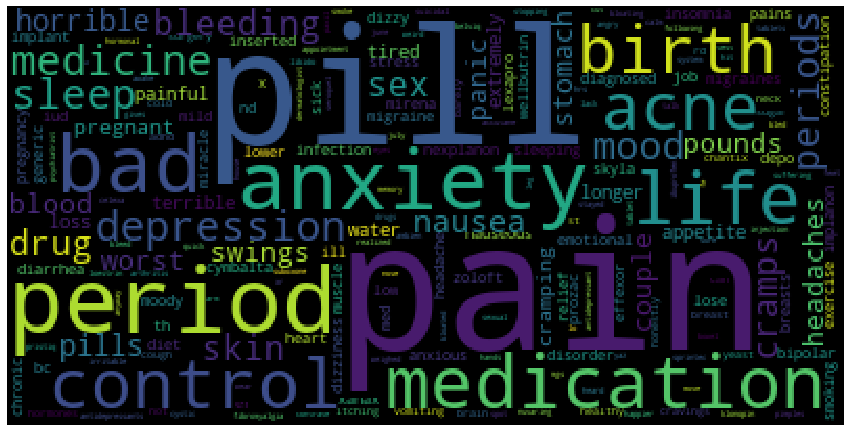

In [15]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
wordcloud = WordCloud().generate_from_frequencies(frequency_dist)
plt.figure( figsize=(15,8) )
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [16]:
from keras.preprocessing.text import Tokenizer
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 250
# This is fixed.
EMBEDDING_DIM = 100
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df_train_fil['review'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Using TensorFlow backend.


Found 34337 unique tokens.


In [17]:
from keras.preprocessing.sequence import pad_sequences
X = tokenizer.texts_to_sequences(df_train_fil['review'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (57398, 250)


In [18]:
Y = pd.get_dummies(df_train_fil['condition']).values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (57398, 34)


In [19]:
from imblearn.over_sampling import SMOTE
smote=SMOTE('minority')
X_sm,y_sm=smote.fit_sample(X,Y)

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


In [20]:
X_train, X_test, Y_train, Y_test = train_test_split(X_sm,y_sm, test_size = 0.10, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(64207, 250) (64207, 34)
(7135, 250) (7135, 34)


In [21]:
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.layers import Dropout
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(34, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 250, 100)          5000000   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 250, 100)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_1 (Dense)              (None, 34)                3434      
Total params: 5,083,834
Trainable params: 5,083,834
Non-trainable params: 0
_________________________________________________________________
None


In [22]:
epochs = 5
batch_size = 64

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 57786 samples, validate on 6421 samples
Epoch 1/5





57786/57786 [==============================] - 371s 6ms/step - loss: 1.8641 - acc: 0.4834 - val_loss: 1.2229 - val_acc: 0.6359
Epoch 2/5
57786/57786 [==============================] - 362s 6ms/step - loss: 0.9137 - acc: 0.7263 - val_loss: 0.8638 - val_acc: 0.7362
Epoch 3/5
57786/57786 [==============================] - 362s 6ms/step - loss: 0.6235 - acc: 0.8108 - val_loss: 0.7811 - val_acc: 0.7708
Epoch 4/5
57786/57786 [==============================] - 353s 6ms/step - loss: 0.4793 - acc: 0.8548 - val_loss: 0.7365 - val_acc: 0.7904
Epoch 5/5
57786/57786 [==============================] - 351s 6ms/step - loss: 0.3927 - acc: 0.8816 - val_loss: 0.7243 - val_acc: 0.7986


In [23]:
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

7135/7135 [==============================] - 31s 4ms/step
Test set
  Loss: 0.650
  Accuracy: 0.818


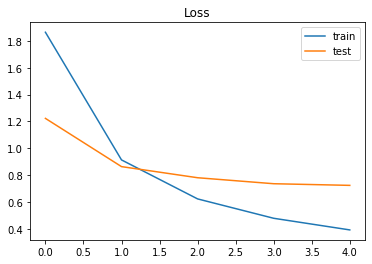

In [29]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

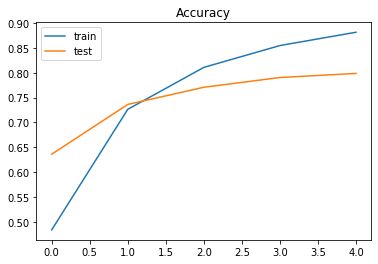

In [32]:
plt.title('Accuracy')
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='test')
plt.legend()
plt.show();

In [0]:
print(history.history)

{'val_loss': [1.3032740156260463, 0.856342522772655, 0.7175680652655312, 0.6727806388198804, 0.6691028300093617], 'val_accuracy': [0.5845214128494263, 0.7331975698471069, 0.7790223956108093, 0.7881873846054077, 0.7970129251480103], 'loss': [1.947168549285571, 1.092885662290657, 0.7579767355806654, 0.584208793717835, 0.47399557336454445], 'accuracy': [0.4373114, 0.6492532, 0.7604481, 0.81299037, 0.84716356]}
